# Prototipo de sistema que ayude en el diagnóstico de patologías cardíacas

El prototipo comienza con la carga de dependencias, todas ellas necesarias para las etapas de filtrado/limpieza de datos y el entrenamiento de l modelo de aprendizaje automático.

In [8]:
import matplotlib.pyplot as plt     # Para graficar
import numpy as np                  # Para manejo de arreglos
import pandas as pd                 # Para manejo dee tablas
import statistics as st             # Para estadísticas (librería estándar)
import scipy.stats as sp            # Para estadísticas (librería científica)
import wfdb                         # Para manejo de bases de datos fisiológicas
import os                           # Para manejo de archivos e interacción con sistema operativo

from scipy.signal import find_peaks                         # Para encontrar picos en señales
from skimage.restoration import denoise_wavelet             # Para filtrado de señales
from scipy.fft import rfft, rfftfreq                        # Para transformada de Fourier
from keras.models import Sequential                         # Para creación de modelos de redes neuronales
from keras.layers import Dense                              # Para creación de capas densas
from keras.optimizers import SGD                            # Para optimización de modelos

Seguido de la definición de las variables globales, funciones classes que serán utilizadas a lo largo del prototipo, es importante señalar que estas deberán ser modificadas para coincidir con la ruta del entorno en donde se ejecuta el prototipo.

In [9]:
# Ruta a la base de datos (desde physionet)
mit_bih_db_path = 'mitdb'
# Ruta a la carpeta de datos del prototipo
prototype_data_path = 'D:\\Servicio Social\\prototipo'

class DataContainer:
    def __init__(self, name, data, headers, annotations):
        self.data = data
        self.headers = headers
        self.annotations = annotations
        self.name = name

class DataManager:
    def __init__(self, db_path, prototype_data_path):
        self.db_path = db_path
        self.prototype_data_path = prototype_data_path
        self.dataset_file_names = wfdb.get_record_list(self.db_path, records='all')
        self.verify_path_in_prototype('')
    
    # Verifica si la carpeta de datos del prototipo existe, en caos de que no la crea        
    def verify_path_in_prototype(self, path):
        if not os.path.exists(f'{self.prototype_data_path}\\{path}'):
            os.makedirs(f'{self.prototype_data_path}\\{path}')
            
    # Obtiene los datos de un archivo de la base de datos
    def get_data(self, file_name, start=0, end=None):
        
        return wfdb.io.rdrecord(file_name, pn_dir=self.db_path, sampfrom=start, sampto=end)
    
    # Obtiene los encabezados de un archivo de la base de datos
    def get_headers(self, file_name):
        return wfdb.io.rdheader(file_name, pn_dir=self.db_path)
    
    # Obtiene las anotaciones de un archivo de la base de datos
    def get_annotations(self, file_name):
        return wfdb.io.rdann(file_name, 'atr', pn_dir=self.db_path)
    
    def get(self, file_name):
        return DataContainer(file_name, self.get_data(file_name), self.get_headers(file_name), self.get_annotations(file_name))
        
    # Obtiene todos los archivos de la base de datos
    def get_all(self):
        data = []
        for file_name in self.dataset_file_names:
            data.append(self.get(file_name))
        return data
    
    def get_all_annotations(self):
        annotations = []
        for file_name in self.dataset_file_names:
            annotations.append(self.get_annotations(file_name))
        return annotations
    

La base de datos contiene archivos con las siguientes extensiones:
- ```.atr``` Anotaciones de los latidos realizadas por expertos
- ```.dat``` Señales de ECG (datos brutos)
- ```.hea``` Encabezados de los archivos metadatos de las señales fisiológicas de los pacientes
- ```.xws``` Información de la señal (escalas, colores o metadatos adicionales)

## Preprocesamiento
Se sugiere restar la base a cada señal y dividir sobre la ganancia (se obtiene amplitud en milivoltios), de esta manera se crea un vector de tiempo (señal en el dominio del tiempo en lugar de la frecuencia). Sin embargo, se recomienda utilizar la normalización estándar de la librería de physionet, si bien, las lecturas incluyen una ganancia, la normalización propuesta no incluye valores mínimos o máximos sobre los cuáles generar los nuevos datos.

A continuación se hace una comparativa de la muestra de uno de los datos sin preprocesamiento y con procesamiento.

Nombre de la muestra: 100
Numero de señales muestreadas a 360/s: 3000


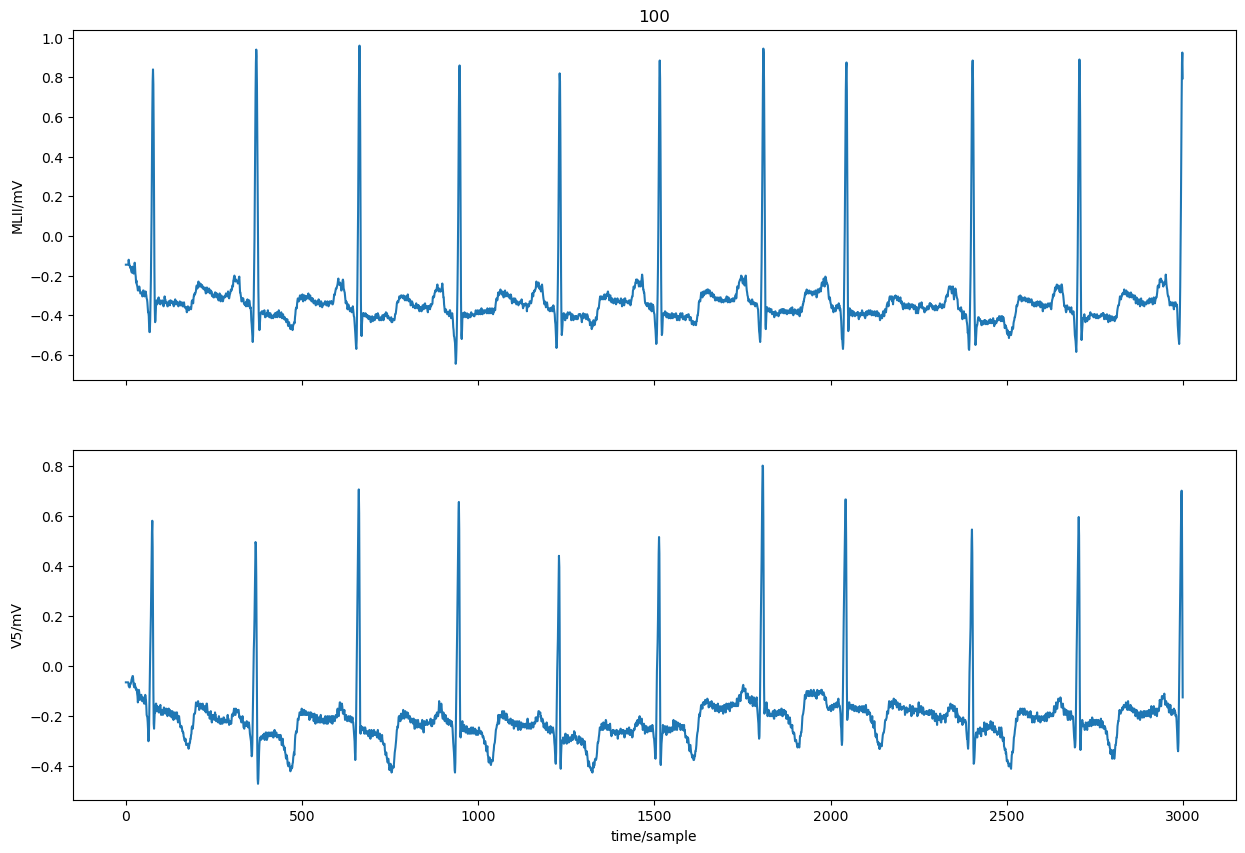

In [10]:
# Instancia gestora de datos
data_manager = DataManager(mit_bih_db_path, prototype_data_path)
# Obtención de muestra
sample_name = data_manager.dataset_file_names[0]
sample = data_manager.get_data(sample_name, 0, 3000)
print(f'Nombre de la muestra: {sample.record_name}\nNumero de señales muestreadas a {sample.fs}/s: {sample.sig_len}')
# Gráfica de la señal sin preprocesamiento
wfdb.plot.plot_wfdb(record=sample, title=sample_name, figsize=(15, 10), time_units='samples')

A continuación se muestra una de las primeras fases del preprocesamiento de la señal descrito anteriormente.

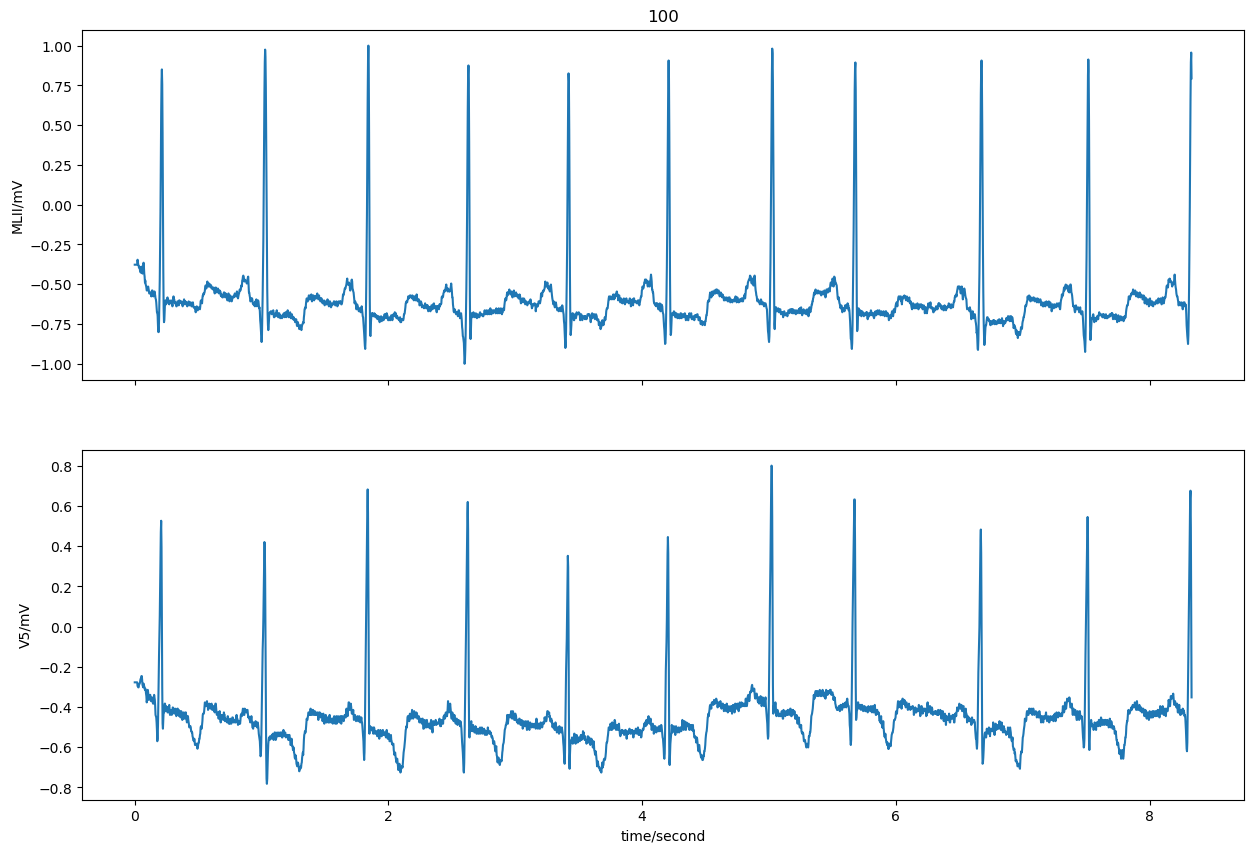

In [11]:
# Código extraído del paquete "wfdb.processing.normalize_bound", no expuesto en la distribución del mismo
def normalize_signal(data, lb=0, ub=1):
    mid = ub - (ub - lb) / 2
    min_v = np.min(data)
    max_v = np.max(data)
    mid_v = max_v - (max_v - min_v) / 2
    coe = (ub - lb) / (max_v - min_v)
    return data * coe - (mid_v * coe) + mid

# Preprocesamiento de la señal
sample.p_signal = normalize_signal(sample.p_signal, lb=-1)
# Gráfica de la señal preprocesada
wfdb.plot.plot_wfdb(record=sample, title=sample_name, figsize=(15, 10), time_units='seconds')

Siguiendo con el preproceamiento de la señal, encontramos la fase de limpieza. Las señales obtenidas contienen ruido, los cuales generando crestas que para efectos del análisis, solo unas cuantas son de interés, para eliminarlas se sugiere aplicar una transformada de fourier con filtros FIR o IIR para después realizar la transformada inversa. Otra alternativa para ello es la aplicación de un wavelet en el filtrado.

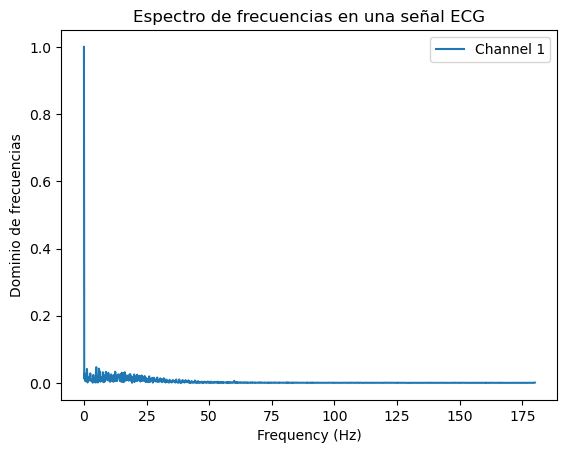

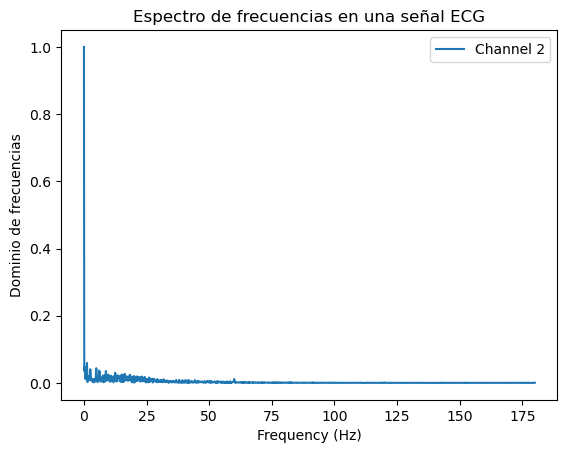

In [12]:
# Transformada de fourier
def fast_fourier_transform(signal, fs):
    y_ecg = rfft(signal)
    y_ecg = np.abs(y_ecg)
    y_ecg = y_ecg / np.ndarray.max(y_ecg)
    x_ecg = rfftfreq(np.size(signal), 1 / fs)
    return x_ecg, y_ecg

# Obtención de la gráfica
ch1_fft_x, ch1_fft_y = fast_fourier_transform(np.array(sample.p_signal[:, 0]), sample.fs)
ch2_fft_x, ch2_fft_y = fast_fourier_transform(np.array(sample.p_signal[:, 1]), sample.fs)

plt.plot(ch1_fft_x, ch1_fft_y, label='Channel 1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Dominio de frecuencias')
plt.title('Espectro de frecuencias en una señal ECG')
plt.legend()
plt.show()
plt.plot(ch2_fft_x, ch2_fft_y, label='Channel 2')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Dominio de frecuencias')
plt.title('Espectro de frecuencias en una señal ECG')
plt.legend()
plt.show()

Ahora utilizando el enfoque wavelet

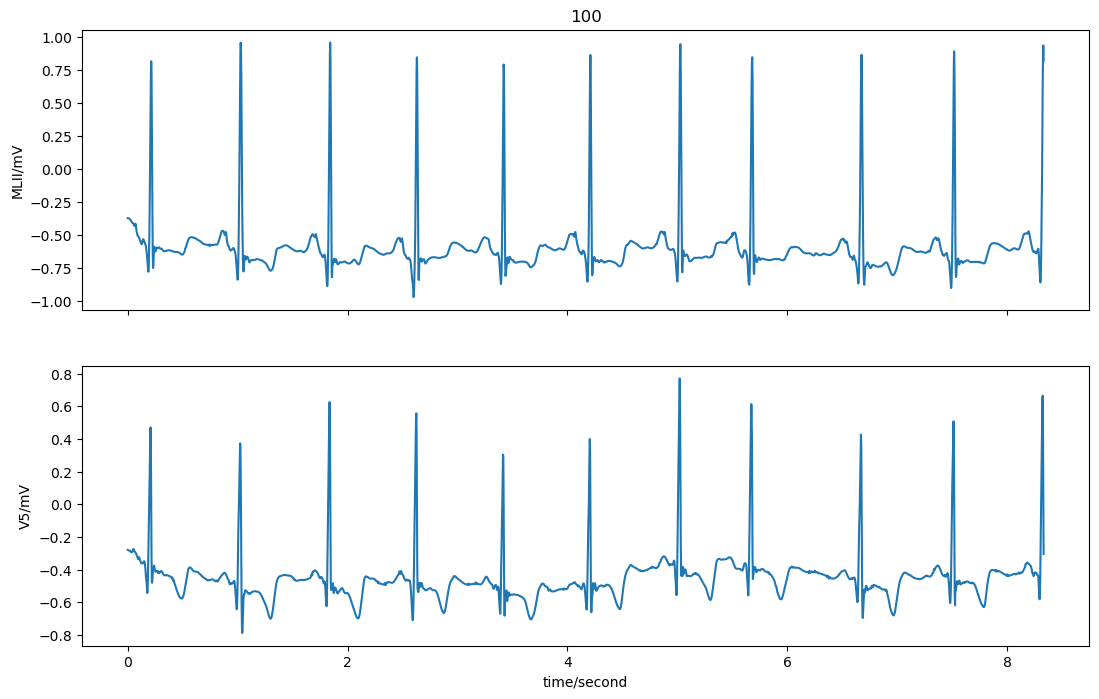

In [13]:
def wavelet_transform(signal):
    return denoise_wavelet(signal, 
                           method='VisuShrink', 
                           mode='soft', 
                           wavelet_levels=6, 
                           wavelet='sym8', 
                           rescale_sigma='True')

def denoise_signal(signal):
    denoised_ch1 = wavelet_transform(np.array(signal[:, 0]))
    denoised_ch2 = wavelet_transform(np.array(signal[:, 1]))
    signal[:, 0] = denoised_ch1
    signal[:, 1] = denoised_ch2

def get_time_vector(signal, freq_sampling):
    return np.linspace(0, np.size(signal), np.size(signal)) * (1 / freq_sampling)

noised_signal = np.copy(sample.p_signal)
denoise_signal(sample.p_signal)
time_vector = get_time_vector(sample.p_signal[:, 0], sample.fs)
# Gráfica de la señal preprocesada
wfdb.plot.plot_wfdb(record=sample, title=sample_name, figsize=(13, 8), time_units='seconds')

Realizando la comparativa con respecto a transformada de fourier sin limpieza y con limpieza

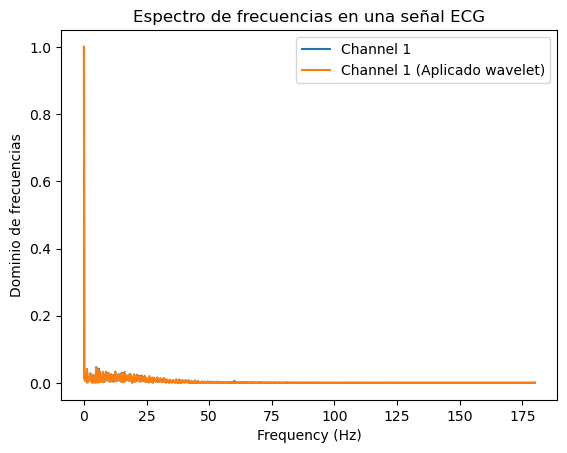

In [14]:
_, ch1_denoise_fft_y = fast_fourier_transform(sample.p_signal[:, 0], sample.fs)
plt.plot(ch1_fft_x, ch1_fft_y, label='Channel 1')
plt.plot(ch1_fft_x, ch1_denoise_fft_y, label='Channel 1 (Aplicado wavelet)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Dominio de frecuencias')
plt.title('Espectro de frecuencias en una señal ECG')
plt.legend()
plt.show()

Finalmente una comparativa de la señal original y la señal limpiada

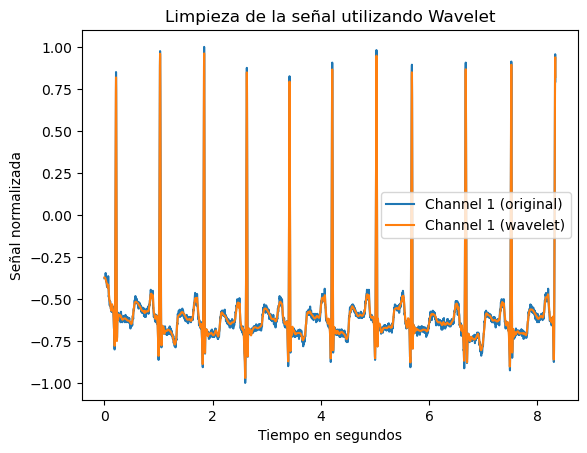

In [15]:
plt.plot(time_vector, noised_signal[:, 0], label='Channel 1 (original)')
plt.plot(time_vector, sample.p_signal[:, 0], label='Channel 1 (wavelet)')
plt.xlabel('Tiempo en segundos')
plt.ylabel('Señal normalizada')
plt.title('Limpieza de la señal utilizando Wavelet')
plt.legend()
plt.show()

# Extracción de características
La extracción de características comienza con la identificación de los picos en la señal, es de interés sólo aquellas que caracterizan al complejo PQRST, a su vez, el complejo PQRS identifica eventos específicos durante el látido, de esta manera se parte de la discriminación de los picos en la onda R.


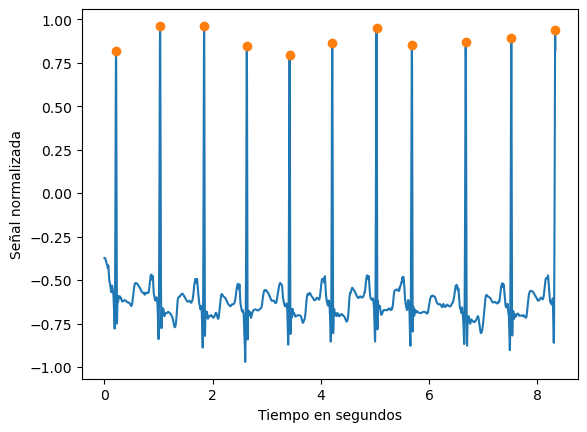

In [16]:
# Obtención de los picos en la señal (onda R)
def umbral_peaks(signal):
    absolute_ch= np.abs(signal)
    umbral_y_ch = np.mean(absolute_ch)
    # Los picos son encontrados en donde el valor de la señal supera a la media 
    peaks_ch1, _ = find_peaks(signal, height=umbral_y_ch)
    return peaks_ch1

ch1_peaks, ch2_peaks = (umbral_peaks(sample.p_signal[:, 0]), umbral_peaks(sample.p_signal[:, 1])) 
plt.plot(time_vector, sample.p_signal[:, 0])
plt.plot(time_vector[ch1_peaks], sample.p_signal[:, 0][ch1_peaks], "o")
plt.xlabel('Tiempo en segundos')
plt.ylabel('Señal normalizada')
plt.show()

Otra de las características a extraer es la variabilidad de la frecuencia cardiaca, el interés en esto es el conocer la fluctuación de los látidos a lo largo del tiempo, aunque estos son variables (hay bajas probabilidades de encontrar una frecuencia estable) se espera un rango de variabilidad en individuos sanos.

La crestas de la onda R facilitan la obtención de estos datos, al medir la distancia R a R (ciclo RR).

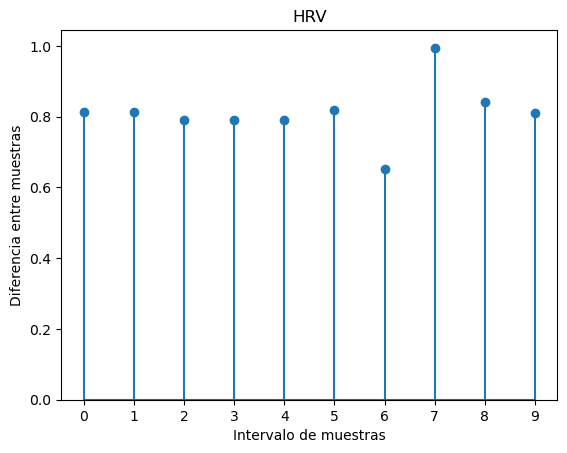

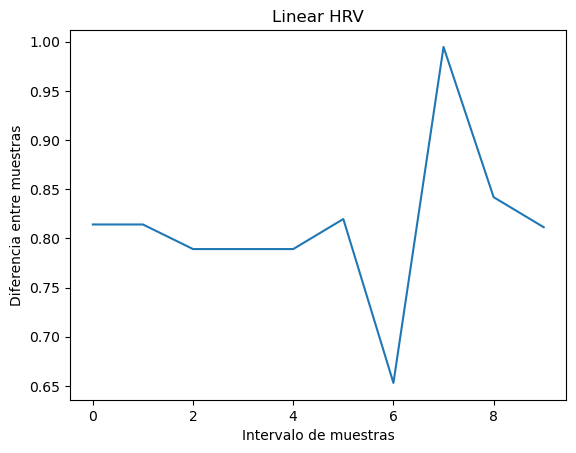

In [17]:
def heart_rate_variability(peaks):
    # Realiza la diferencia entre cada una de las muestras, el resultado lo almacena en otro arreglo
    hrv = np.diff(peaks)
    tam = np.size(hrv)
    return hrv

hrv_ch1 = heart_rate_variability(time_vector[ch1_peaks])
fig, axes = plt.subplots()
axes.stem(np.arange(0, np.size(hrv_ch1)), hrv_ch1)
axes.set_ylim(0)

plt.title("HRV")
plt.xlabel("Intervalo de muestras")
plt.ylabel("Diferencia entre muestras")
plt.xticks(np.arange(0, np.size(hrv_ch1)))
plt.show()
plt.title("Linear HRV")
plt.xlabel("Intervalo de muestras")
plt.ylabel("Diferencia entre muestras")
plt.plot(np.arange(0, np.size(hrv_ch1)), hrv_ch1)
plt.show()

A partir de esta información se obtienen los latidos por segundo realizando:
$$
BPM=\frac{60}{\text{intervalo}(RR)}
$$

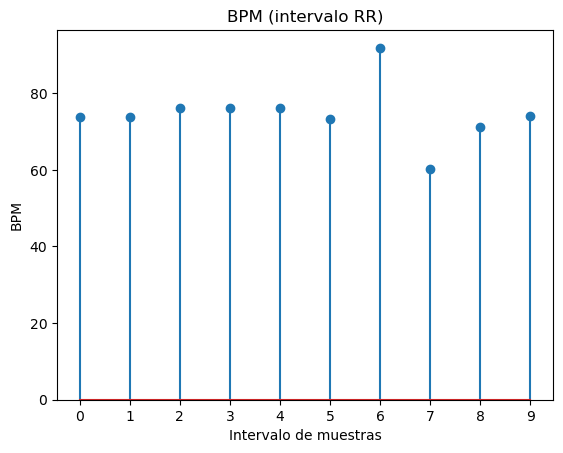

In [18]:
def get_bpm(rr_interval):
    return (1 / rr_interval) * 60

bpm_ch1 = get_bpm(hrv_ch1)
_, axes = plt.subplots()
axes.stem(np.arange(0, np.size(bpm_ch1)), bpm_ch1)
axes.set_ylim(0)
plt.title("BPM (intervalo RR)")
plt.xlabel("Intervalo de muestras")
plt.ylabel("BPM")
plt.xticks(np.arange(0, np.size(bpm_ch1)))
plt.show()

Siguiendo con la extracción de características, se obtiene el RMSSD (Root Mean Squeare of the Successive Differences) como valor estadístico para la variabilidad de la frecuencia cardiaca, esto al comparar la media actual de las muestras con la anterior, de esta manera se obtiene con pocas mediciones si hay una variabilidad significativas en alguna de las muestras.
$$
RMSSD=\sqrt{\sum_{i=1}^{n-1}(\frac{RR_{i}-RR_{i+1})^2}{n-1}}
$$

In [19]:
def rmssd(hrv):
    suma = 0
    # Realiza la diferencia entre cada una de las muestras, el resultado lo almacena en otro arreglo 
    resta_rr = np.diff(hrv)
    if np.size(resta_rr) == 0:
        return 0
    # Eleva al cuadrado las diferencias y las suma
    squared_numbers = [number ** 2 for number in resta_rr]
    for num in squared_numbers:
        suma += num
    normalize = suma / np.size(resta_rr)
    rmssd_value = np.sqrt(normalize)
    return rmssd_value*1000
        
rmssd_ch1 = rmssd(hrv_ch1)
print(f'RMSSD: {rmssd_ch1}')
    

RMSSD: 137.62301319372884


La métrica PNN25, PNN50 y PNN75 se consideran en la extracción de las características. Este grupo se le conoce como PNNX, donde X son los intervalos consecutivos que difieren en más de 25, 50 y 75 ms (NNX, donde X es el número de milisegundos) respectivamente. Para ello se realiza la siguiente operación:
$$
PNNX=\frac{NNX}{n-1}\cdot 100
$$

In [20]:
def pnnx(hrv, x):
    # Valor absoluto de las diferencias entre intervalo RR
    resta_rr = np.abs(np.diff(hrv))
    if np.size(resta_rr) == 0:
        return 0, 0
    filtering_condition = resta_rr > (x / 1000)
    # Obtiene el conteo de todos los elementos cuya diferencia es mayor a x
    cumulative_sum = np.size(resta_rr[filtering_condition])
    return (cumulative_sum / np.size(resta_rr)) * 100, cumulative_sum

pnn50, cumulative_sum = pnnx(hrv_ch1, 50)
print(pnn50, cumulative_sum)

33.33333333333333 3


Finalmente, encontramos las características estadísticas de la señal, esto con la finalidad de reducir la dimensionalidad. Estas características son:
1. Mínimo de la señal
2. Máximo de la señal
3. Media aritmética
4. Mediana de la señal
5. Suma de todos los valores de la señal
6. Desviación estándar
7. La variación de la señal
8. La Kurtosis
9. Entropía de Shannon
10. Entropía energética logarítmica
11. La asimetría de la señal
La siguiente clase facilita la obtención de las características mencionadas.

In [21]:
def get_shannon(signal):
    y = np.power(signal, 2)
    y1 = np.sum(y)
    pe = y / y1
    se = -np.sum(pe * np.log(np.power(pe, 2)))
    return se

def get_logenergy(signal):
    y = np.power(signal, 2)
    y1 = np.sum(y)
    pe = y / y1
    lee = np.sum(pe * np.log(pe))
    return lee

def statistics(signal):
    min_value = np.min(signal)
    max_value = np.max(signal)
    mean_value = np.mean(signal)
    median_value = np.median(signal)
    sum_value = np.sum(signal)
    std_value = st.stdev(signal)
    var_value = st.variance(signal)
    skw_value = sp.skew(signal) 
    kurtosis_value = sp.kurtosis(signal)
    shannon_entropy = get_shannon(signal)
    energy_entropy = get_logenergy(signal)
    return min_value, max_value, mean_value, median_value, sum_value, std_value, var_value, skw_value, kurtosis_value, shannon_entropy, energy_entropy

# Carga de dataset para entrenamiento y pruebas
Este proceso se conoce como segmentación, para ello será necesario dividir el dataset. Para extraer los datos de interés será necesario verificar la información de las muestras de los pacientes, utilizando las anotaciones proporcionadas por los expertos en la base de datos. Se require 5 clases de latidos, cada una identificada por una letra en las anotaciones:

| Abreviación | Nombre                            | Descripción                       | Símbolo (Tipo) | Letra (Cadena Subtipo) |
|-------------|-----------------------------------|-----------------------------------|----------------|------------------------|
| NSR         | Normal Sinus Rhythm               | Latidos normales                  | N              | N                      |
| LBBB        | Left Branch Block Beat            | Bloqueo de la rama izquierda      | L              |                        |
| PVC         | Premature Ventricular Contraction | Contracción Ventricular Prematura | V              |                        |
| AFIB        | Atrial Fibrilation                | Fibrilación Auricular             |                | AFIB                   |

Con el siguiente script podremos identificar aquellas muestras que contienen las clases de interés.

In [22]:
# Tabla que contiene los símbolos de interés y su descripción
symbols_table = pd.DataFrame([
    ['N', 'Normal Sinus Rhythm'],
    ['·', 'Normal Sinus Rhythm'],
    ['L', 'Left Branch Block Beat'],
    # ['R', 'Right Branch Block Beat'],
    # ['A', 'Atrial Premature Contraction'],
    # ['a', 'Aberrated Atrial Premature Contraction'],
    # ['J', 'Nodal (junctional) Premature Contraction'],
    # ['S', 'Supraventricular Premature or Ectopic Beat'],
    ['V', 'Premature Ventricular Contraction'],
    # ['F', 'Fusion of ventricular and normal beat'],
    # ['[', 'Start of Ventricular Flutter'],
    # ['!', 'Start of Ventricular Flutter'],
    # [']', 'Start of Ventricular Flutter'],
    # ['e', 'Atrial Escape Beat'],
    # ['j', 'Nodal (junctional) Escape Beat'],
    # ['E', 'Ventricular Escape Beat'],
    # ['/', 'Paced Beat'],
    # ['f', 'Fusion of paced and normal beat'],
    # ['n', 'Supraventricular Escape Beat'],
    # ['Q', 'Unclassifiable Beat'],
    # ['?', 'Beat not classified during learning'],
    # ['|', 'Isolated QRS-like artifact']
], columns=['symbol', 'Name'])

# Tabla que contiene las clases de interés
subtype_table = pd.DataFrame([
    # ['(AB\x00', 'Atrial bigeminy'],
    ['(AFIB\x00', 'Atrial fibrillation'],
    # ['(AFL\x00', 'Atrial flutter'],
    # ['(B\x00', 'Ventricular bigeminy'],
    # ['(BII\x00', '2° heart block'],
    # ['(IVR\x00', 'Idioventricular rhythm'],
    # ['(N\x00', 'Normal sinus rhythm'],
    # ['(NOD\x00', 'Nodal (A-V junctional) rhythm'],
    # ['(P\x00', 'Paced rhythm'],
    # ['(PREX\x00', 'Pre-excitation (WPW)'],
    # ['(SBR\x00', 'Sinus bradycardia'],
    # ['(SVTA\x00', 'Supraventricular tachyarrhythmia'],
    # ['(T\x00', 'Ventricular trigeminy'],
    # ['(VFL\x00', 'Ventricular flutter'],
    # ['(VT\x00', 'Ventricular tachycardia']
], columns=['string', 'Name'])

# Construye una tabla de intervalos con sus respectivas clases y símbolos
def get_annotations_table(data_container):
    annotation_data = {
        'name': [],
        'symbol': [],
        'aux': [],
        'start_sample': [],
        'length': []
    }
    for container in data_container:
        size = np.size(container.annotations.symbol)
        for i in range(0, size - 1):
            symbol = container.annotations.symbol[i]
            annotation_data['name'].append(container.annotations.record_name)
            annotation_data['symbol'].append(symbol)
            annotation_data['aux'].append(container.annotations.aux_note[i])
            annotation_data['start_sample'].append(container.annotations.sample[i])
            annotation_data['length'].append(container.annotations.sample[i + 1] - container.annotations.sample[i])
        symbol = container.annotations.symbol[-1]
        annotation_data['name'].append(container.annotations.record_name)
        annotation_data['symbol'].append(symbol)
        annotation_data['aux'].append(container.annotations.aux_note[-1])
        annotation_data['start_sample'].append(container.annotations.sample[-1])
        annotation_data['length'].append(np.size(container.data.p_signal[:,0]) - container.annotations.sample[-1])
    return pd.DataFrame(annotation_data)
    
ann = get_annotations_table(data_manager.get_all())
ann

,name,symbol,aux,start_sample,length
0,100,+,(N ,18,59
1,100,N,,77,293
2,100,N,,370,292
3,100,N,,662,284
4,100,N,,946,285
...,...,...,...,...,...
112642,234,N,,648797,243
112643,234,N,,649040,252
112644,234,N,,649292,244
112645,234,N,,649536,236


Una vez extraída la información tabular, se procede a realizar la filtración de las clases de interés y se crean segmentos de muestras de longitud 3600 o más. 

In [23]:
# Obtiene todas las clases de interés
filtered_types = ann[ann['symbol'].isin(symbols_table['symbol'])]
filtered_aux = ann[ann['aux'].isin(subtype_table['string'])]

class ChunkManager:
    def __init__(self, table):
        self.table = table
        self.chunks = {
            'name': [],
            'symbol': [],
            'start_sample': [],
            'length': []
        }
        self.current_symbol = table.symbol.iat[0]
        self.current_name = table.name.iat[0]
        self.start = 0
        self.length = 0
    
    def get_chunks(self):
        for row in self.table.itertuples():
            if row.symbol != self.current_symbol or self.current_name != row.name:
                self.submit_chunk()
                self.set_aux(row.symbol, row.name, row.start_sample)
            if self.length > 3600:
                self.submit_chunk()
                self.set_aux(row.symbol, row.name, row.start_sample)
            self.length += row.length
            
    def submit_chunk(self):
        self.chunks['name'].append(self.current_name)
        self.chunks['symbol'].append(self.current_symbol)
        self.chunks['start_sample'].append(self.start)
        self.chunks['length'].append(self.length)
        
    def set_aux(self, symbol, name, start, length = 0):
        self.current_name = name
        self.current_symbol = symbol
        self.start = start
        self.length = length

chunk_manager = ChunkManager(filtered_types)
chunk_manager.get_chunks()
chunks_table = pd.DataFrame(chunk_manager.chunks)
chunks_table

,name,symbol,start_sample,length
0,100,N,0,3735
1,100,N,4170,3783
2,100,N,7953,3828
3,100,N,11781,3826
4,100,N,15607,3781
...,...,...,...,...
16780,234,N,630711,3741
16781,234,N,634452,3632
16782,234,N,638084,3683
16783,234,N,641767,3643


In [24]:
normal_chunks = chunks_table[chunks_table['symbol'].isin(['N'])].sort_values(by='length', ascending=False)
normal_chunks

,name,symbol,start_sample,length
12239,219,N,294487,4116
4819,123,N,70,4084
4845,123,N,99686,4082
4884,123,N,244408,4077
4846,123,N,103768,4073
...,...,...,...,...
7701,203,N,414945,71
8014,205,N,333687,67
12301,219,N,500976,61
5255,200,N,116262,61


In [25]:
lbbb_chunks = chunks_table[chunks_table['symbol'].isin(['L'])].sort_values(by='length', ascending=False)
lbbb_chunks

,name,symbol,start_sample,length
8284,207,L,544865,3939
8274,207,L,505842,3932
8282,207,L,537031,3918
8283,207,L,540949,3916
8213,207,L,272038,3910
...,...,...,...,...
11122,214,L,51472,142
11201,214,L,133984,142
8152,207,L,48019,114
11098,214,L,28035,78


In [26]:
pvc_chunks = chunks_table[chunks_table['symbol'].isin(['V'])].sort_values(by='length', ascending=False)
pvc_chunks

,name,symbol,start_sample,length
4995,124,V,219980,4093
8127,207,V,5648,4063
8157,207,V,70665,4026
8156,207,V,64967,3926
4994,124,V,115412,3903
...,...,...,...,...
9170,208,V,323484,64
1820,108,V,393056,64
1887,108,V,619235,64
7599,203,V,326696,34


In [27]:
records_with_afib = filtered_aux['name'].unique()
whole_with_afib = ann[ann['name'].isin(records_with_afib)]
whole_with_afib

,name,symbol,aux,start_sample,length
51016,201,+,(AFIB ,60,99
51017,201,N,,159,256
51018,201,N,,415,271
51019,201,N,,686,219
51020,201,N,,905,284
...,...,...,...,...,...
95649,222,N,,648985,172
95650,222,N,,649157,160
95651,222,N,,649317,283
95652,222,N,,649600,259


In [28]:
filtered_aux

,name,symbol,aux,start_sample,length
51016,201,+,(AFIB ,60,99
51655,201,+,(AFIB ,171815,68
52742,201,+,(AFIB ,574742,60
54116,202,+,(AFIB ,411338,54
54170,202,+,(AFIB ,423479,53
...,...,...,...,...,...
94319,222,+,(AFIB ,348977,78
94876,222,+,(AFIB ,478549,74
94946,222,+,(AFIB ,493713,134
95084,222,+,(AFIB ,526850,98


Para cada una de las clases se requiren por lo menos 100 muestras para el entrenamiento del modelo. Se seleccionan los segmentos de mayor duraciòn para cada una de las clases.

In [29]:
# Obtiene los registros de la base de datos necesarios
def get_records_symbol(table, until):
    records = []
    count = 0
    for row in table.itertuples():
        if count >= until:
            break
        records.append(DataContainer(row.name, data_manager.get_data(row.name, row.start_sample, row.start_sample + row.length), None, None))
        count += 1
    return records

normal_records = get_records_symbol(normal_chunks, 100)
lbbb_records = get_records_symbol(lbbb_chunks, 100)
pvc_records = get_records_symbol(pvc_chunks, 100)

In [30]:
def get_aux_chunks(table, max_length = 3600):
    chunks = {
            'name': [],
            'symbol': [],
            'start_sample': [],
            'length': []
        }
    current_symbol = table.aux.iat[0]
    current_name = table.name.iat[0]
    start = 0
    length = 0
    for row in table.itertuples():
        if row.aux != '':
            if row.aux != current_symbol or current_name != row.name:
                chunks['name'].append(current_name)
                chunks['symbol'].append(current_symbol)
                chunks['start_sample'].append(start)
                chunks['length'].append(length)
                current_name = row.name
                current_symbol = row.aux
                start = row.start_sample
                length = 0
        if length > max_length:
            chunks['name'].append(current_name)
            chunks['symbol'].append(current_symbol)
            chunks['start_sample'].append(start)
            chunks['length'].append(length)
            current_name = row.name
            start = row.start_sample
            length = 0
        length += row.length
    return pd.DataFrame(chunks)
    
whole_with_afib


,name,symbol,aux,start_sample,length
51016,201,+,(AFIB ,60,99
51017,201,N,,159,256
51018,201,N,,415,271
51019,201,N,,686,219
51020,201,N,,905,284
...,...,...,...,...,...
95649,222,N,,648985,172
95650,222,N,,649157,160
95651,222,N,,649317,283
95652,222,N,,649600,259


In [31]:
whole_with_afib_chunks = get_aux_chunks(whole_with_afib)
whole_with_afib_chunks

,name,symbol,start_sample,length
0,201,(AFIB ,0,3738
1,201,(AFIB ,3798,3816
2,201,(AFIB ,7614,3686
3,201,(AFIB ,11300,3714
4,201,(AFIB ,15014,3667
...,...,...,...,...
1373,222,(AFL,628425,3800
1374,222,(AFL,632225,3611
1375,222,(AFL,635836,3823
1376,222,(AFL,639659,3709


In [32]:
afib_chunks = whole_with_afib_chunks[whole_with_afib_chunks['symbol'].isin(subtype_table['string'])].sort_values(by='length', ascending=False)
afib_chunks

,name,symbol,start_sample,length
963,221,(AFIB ,70559,4051
520,203,(AFIB ,470798,4003
895,219,(AFIB ,476585,3998
1060,221,(AFIB ,388731,3990
402,203,(AFIB ,101119,3986
...,...,...,...,...
1234,222,(AFIB ,312335,310
405,203,(AFIB ,109079,214
340,202,(AFIB ,549680,113
1016,221,(AFIB ,253224,83


In [33]:
afib_records = get_records_symbol(afib_chunks, 100)
afib_records

Se propone la siguiente clase para la automatización de la extracción de limpieza de señales, normalización y extracción de características.

In [34]:
class FeatureExtractor:
    def __init__(self, data):
        self.data_containers = data
        self.features_table = pd.DataFrame(columns = [
            "name",
            'data_ref (channel)',
            'min', 
            'max', 
            'mean', 
            'median', 
            'sum', 
            'std', 
            'var',
            'skew',
            'kurtosis',
            'shannon ent',
            'log energy',
            'pnn25',
            'nn25',
            'pnn50',
            'nn50',
            'pnn75',
            'nn75',
            'rmssd'
        ])
    
    def start_characterization(self):
        self.normalize_signals()
        self.denoise_signals()
        self.extract_features()
        return self.features_table
    
    def extract_features(self):
        rows = []
        for item in self.data_containers:
            for i in range(np.size(item.data.p_signal, 1)):
                min_value, max_value, mean_value, median_value, sum_value, std_value, var_value, skw_value, kurtosis_value, shannon_entropy, energy_entropy = statistics(item.data.p_signal[:, i])
                time = get_time_vector(item.data.p_signal[:, i], item.data.fs)
                peaks = umbral_peaks(item.data.p_signal[:, i])
                hrv = heart_rate_variability(time[peaks])
                rmssd_value = rmssd(hrv)
                pnn25, nn25 = pnnx(hrv, 25)
                pnn50, nn50 = pnnx(hrv, 50)
                pnn75, nn75 = pnnx(hrv, 75)
                rows.append({
                    "name": item.name,
                    'data_ref (channel)': i,
                    "min": min_value, 
                    "max": max_value, 
                    "mean": mean_value, 
                    "median": median_value, 
                    "sum": sum_value, 
                    "std": std_value, 
                    "var": var_value,
                    "skew": skw_value,
                    "kurtosis": kurtosis_value,
                    "shannon ent": shannon_entropy,
                    "log energy": energy_entropy,
                    "pnn25": pnn25,
                    "nn25": nn25,
                    "pnn50": pnn50,
                    "nn50": nn50,
                    "pnn75": pnn75,
                    "nn75": nn75,
                    "rmssd": rmssd_value
                })
        self.features_table = pd.concat([self.features_table, pd.DataFrame(rows)], ignore_index=True)
    
    def normalize_signals(self):
        for data in self.data_containers:
            data.data.p_signal = normalize_signal(data.data.p_signal, lb=-1)
    
    def denoise_signals(self):
        for data in self.data_containers:
            denoise_signal(data.data.p_signal)

In [35]:
# Instancia de la clase FeatureExtractor
feature_extractor_afib = FeatureExtractor(afib_records)
feature_extractor_normal = FeatureExtractor(normal_records)
feature_extractor_lbb = FeatureExtractor(lbbb_records)
feature_extractor_pvc = FeatureExtractor(pvc_records)

In [36]:
afib_feat = feature_extractor_afib.start_characterization()
afib_feat = afib_feat[afib_feat['data_ref (channel)'] == 0]
afib_feat

C:\Users\LAMM_\AppData\Local\Temp\ipykernel_15704\2167821247.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_table = pd.concat([self.features_table, pd.DataFrame(rows)], ignore_index=True)


,name,data_ref (channel),min,max,mean,median,sum,std,var,skew,kurtosis,shannon ent,log energy,pnn25,nn25,pnn50,nn50,pnn75,nn75,rmssd
0,221,0,-0.840450,0.975522,-0.296425,-0.335372,-1200.816790,0.228778,0.052340,2.537822,10.013979,16.058647,-8.029323,91.666667,11,83.333333,10,75.000000,9,297.693504
2,203,0,-0.994122,0.985416,0.035302,0.011777,141.314702,0.203485,0.041406,1.343444,7.292905,12.773774,-6.386887,100.000000,16,100.000000,16,100.000000,16,422.461372
4,219,0,-0.955411,0.995636,-0.239883,-0.262659,-959.053981,0.281159,0.079051,1.259627,3.532832,15.418991,-7.709495,91.666667,11,83.333333,10,75.000000,9,325.443261
6,221,0,-0.824651,0.975899,-0.314314,-0.345599,-1254.112176,0.241235,0.058194,2.524967,9.407922,16.081513,-8.040757,100.000000,13,84.615385,11,84.615385,11,295.947379
8,203,0,-0.983836,0.979547,-0.078568,-0.108838,-313.172186,0.244519,0.059789,1.103433,2.640868,14.843978,-7.421989,100.000000,15,86.666667,13,80.000000,12,239.068345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,210,0,-0.988140,0.967868,-0.298517,-0.328692,-1141.529364,0.239558,0.057388,2.737583,9.562338,16.014498,-8.007249,83.333333,10,58.333333,7,41.666667,5,152.704032
192,221,0,-0.766509,0.971247,-0.284235,-0.320660,-1086.346496,0.216402,0.046830,3.201883,13.288095,16.022437,-8.011219,91.666667,11,91.666667,11,66.666667,8,227.766787
194,219,0,-0.804495,0.991483,-0.318599,-0.363591,-1217.684028,0.290769,0.084547,1.483220,3.399217,15.716559,-7.858279,81.818182,9,72.727273,8,54.545455,6,201.809259
196,210,0,-0.990374,0.976141,-0.658416,-0.687189,-2516.466503,0.295772,0.087481,3.532504,13.522374,16.375464,-8.187732,70.000000,7,60.000000,6,60.000000,6,326.925061


In [37]:
normal_feat = feature_extractor_normal.start_characterization()
normal_feat = normal_feat[normal_feat['data_ref (channel)'] == 0]
normal_feat

C:\Users\LAMM_\AppData\Local\Temp\ipykernel_15704\2167821247.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_table = pd.concat([self.features_table, pd.DataFrame(rows)], ignore_index=True)


,name,data_ref (channel),min,max,mean,median,sum,std,var,skew,kurtosis,shannon ent,log energy,pnn25,nn25,pnn50,nn50,pnn75,nn75,rmssd
0,219,0,-0.796708,0.991479,-0.245751,-0.304643,-1011.512777,0.277775,0.077159,1.315631,2.751026,15.702125,-7.851063,100.000000,11,72.727273,8,72.727273,8,168.832192
2,123,0,-0.985659,0.984659,-0.415703,-0.451285,-1697.730893,0.175679,0.030863,4.349533,26.850282,16.429728,-8.214864,85.714286,6,57.142857,4,57.142857,4,104.309866
4,123,0,-1.000386,0.986891,-0.366598,-0.399928,-1496.454216,0.172880,0.029887,4.484887,28.127924,16.376014,-8.188007,85.714286,6,71.428571,5,57.142857,4,168.984189
6,123,0,-0.991403,0.973832,-0.327308,-0.362450,-1334.436293,0.169543,0.028745,4.199660,26.379389,16.292976,-8.146488,71.428571,5,71.428571,5,71.428571,5,98.804271
8,123,0,-0.984341,0.984608,-0.399598,-0.433213,-1627.560689,0.170322,0.029010,4.595027,29.318904,16.427047,-8.213523,71.428571,5,57.142857,4,42.857143,3,73.720873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,123,0,-0.980202,0.991145,-0.409168,-0.447362,-1617.030019,0.173084,0.029958,4.620486,29.146332,16.376209,-8.188105,83.333333,5,66.666667,4,33.333333,2,69.127799
192,117,0,-0.980423,0.219618,-0.442301,-0.489520,-1747.529811,0.143447,0.020577,1.532621,3.914415,16.298193,-8.149096,0.000000,0,0.000000,0,0.000000,0,0.000000
194,117,0,-0.976090,0.156203,-0.335488,-0.368117,-1325.178699,0.136550,0.018646,0.596926,3.510240,16.139073,-8.069537,0.000000,0,0.000000,0,0.000000,0,0.000000
196,202,0,-0.525350,0.974804,-0.120459,-0.148467,-475.814703,0.169947,0.028882,2.743774,12.320556,14.973798,-7.486899,50.000000,4,25.000000,2,0.000000,0,37.829713


In [38]:
lbb_feat = feature_extractor_lbb.start_characterization()
lbb_feat = lbb_feat[lbb_feat['data_ref (channel)'] == 0]
lbb_feat

C:\Users\LAMM_\AppData\Local\Temp\ipykernel_15704\2167821247.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_table = pd.concat([self.features_table, pd.DataFrame(rows)], ignore_index=True)


,name,data_ref (channel),min,max,mean,median,sum,std,var,skew,kurtosis,shannon ent,log energy,pnn25,nn25,pnn50,nn50,pnn75,nn75,rmssd
0,207,0,-0.966532,0.822774,0.244311,0.262305,962.341522,0.280020,0.078411,-1.102967,2.494393,15.480374,-7.740187,77.419355,24,67.741935,21,67.741935,21,579.041833
2,207,0,-0.954104,0.750940,0.302279,0.290610,1188.560963,0.279230,0.077970,-1.631178,4.472402,15.761296,-7.880648,77.777778,14,72.222222,13,66.666667,12,717.570459
4,207,0,-0.960379,0.607553,0.205659,0.192968,805.772254,0.254447,0.064743,-1.675059,4.620987,15.413812,-7.706906,91.666667,22,87.500000,21,79.166667,19,699.609962
6,207,0,-0.988828,0.717341,0.242575,0.251330,949.924207,0.258028,0.066578,-1.454125,3.820511,15.567420,-7.783710,73.333333,22,70.000000,21,63.333333,19,545.621147
8,207,0,-0.961077,0.976210,0.410405,0.428125,1604.682780,0.290325,0.084289,-1.675849,4.572938,15.995203,-7.997602,76.785714,43,66.071429,37,53.571429,30,405.098360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,111,0,-0.989087,0.906337,0.054571,0.033732,209.662369,0.231865,0.053762,0.100585,0.817152,14.733913,-7.366957,78.571429,55,72.857143,51,70.000000,49,220.715135
192,109,0,-0.751209,0.993283,-0.238128,-0.265406,-914.173590,0.256254,0.065666,1.989049,6.317130,15.563251,-7.781625,55.555556,5,33.333333,3,22.222222,2,334.728401
194,109,0,-0.792244,0.993131,-0.247628,-0.278059,-950.642011,0.307907,0.094807,1.928777,4.925408,15.544093,-7.772046,50.000000,6,0.000000,0,0.000000,0,24.288723
196,109,0,-0.827299,0.996244,-0.263434,-0.297129,-1011.323189,0.305984,0.093626,1.836199,4.504571,15.642357,-7.821179,25.000000,3,8.333333,1,0.000000,0,26.126288


In [39]:
pvc_feat = feature_extractor_pvc.start_characterization()
pvc_feat = pvc_feat[pvc_feat['data_ref (channel)'] == 0]
pvc_feat

D:\Programs\anaconda3\envs\ecg\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\LAMM_\AppData\Local\Temp\ipykernel_15704\2167821247.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_table = pd.concat([self.features_table, pd.DataFrame(rows)], ignore_index=True)


,name,data_ref (channel),min,max,mean,median,sum,std,var,skew,kurtosis,shannon ent,log energy,pnn25,nn25,pnn50,nn50,pnn75,nn75,rmssd
0,124,0,-0.991108,0.996688,-0.076862,-0.110571,-314.598136,0.193415,0.037410,2.051965,10.112455,14.091924,-7.045962,70.000000,7,50.000000,5,10.000000,1,307.315388
2,207,0,-0.737608,0.753087,-0.037011,-0.018259,-150.377372,0.251699,0.063352,-0.368786,0.800031,14.458505,-7.229252,74.193548,23,70.967742,22,64.516129,20,626.960938
4,207,0,-0.986959,0.522178,-0.336436,-0.352826,-1354.490366,0.158918,0.025255,-0.301709,6.501537,15.971570,-7.985785,100.000000,2,50.000000,1,50.000000,1,1412.868007
6,207,0,-0.988348,0.488249,-0.190246,-0.223176,-746.906679,0.184988,0.034221,-0.766860,3.466220,15.042820,-7.521410,66.666667,2,66.666667,2,33.333333,1,57.526505
8,124,0,-0.995052,0.992304,0.172217,0.219734,672.163507,0.366462,0.134295,-0.418361,0.815316,14.915968,-7.457984,85.714286,12,71.428571,10,71.428571,10,677.331809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,106,0,-0.975509,0.972761,-0.277087,-0.301173,-188.696374,0.305064,0.093064,1.104064,2.743873,12.132681,-6.066341,0.000000,0,0.000000,0,0.000000,0,0.000000
192,214,0,-0.987764,0.980775,0.045070,-0.031320,30.692996,0.350078,0.122555,-0.171817,1.372755,10.640334,-5.320167,100.000000,1,100.000000,1,100.000000,1,80.674020
194,106,0,-0.995640,0.992592,-0.201344,-0.250176,-136.712656,0.323750,0.104814,1.124764,2.669041,11.783224,-5.891612,100.000000,1,100.000000,1,100.000000,1,183.603736
196,106,0,-0.752048,0.954721,-0.081306,-0.157029,-55.125410,0.281354,0.079160,1.137381,2.038402,11.354787,-5.677393,0.000000,0,0.000000,0,0.000000,0,0.000000


In [42]:
# Preparapación de los datos para el entrenamiento del modelo
afib_feat = afib_feat.drop('name', axis=1)
normal_feat = normal_feat.drop('name', axis=1)
lbb_feat = lbb_feat.drop('name', axis=1)
pvc_feat = pvc_feat.drop('name', axis=1)
afib_feat = afib_feat.drop('data_ref (channel)', axis=1)
normal_feat = normal_feat.drop('data_ref (channel)', axis=1)
lbb_feat = lbb_feat.drop('data_ref (channel)', axis=1)
pvc_feat = pvc_feat.drop('data_ref (channel)', axis=1)

In [43]:
afib_feat['label'] = 'AFIB'
normal_feat['label'] = 'N'
lbb_feat['label'] = 'L'
pvc_feat['label'] = 'V'

In [45]:
input_table = pd.concat([afib_feat, normal_feat, lbb_feat, pvc_feat], ignore_index=True)
input_table

,min,max,mean,median,sum,std,var,skew,kurtosis,shannon ent,log energy,pnn25,nn25,pnn50,nn50,pnn75,nn75,rmssd,label
0,-0.840450,0.975522,-0.296425,-0.335372,-1200.816790,0.228778,0.052340,2.537822,10.013979,16.058647,-8.029323,91.666667,11,83.333333,10,75.000000,9,297.693504,AFIB
1,-0.994122,0.985416,0.035302,0.011777,141.314702,0.203485,0.041406,1.343444,7.292905,12.773774,-6.386887,100.000000,16,100.000000,16,100.000000,16,422.461372,AFIB
2,-0.955411,0.995636,-0.239883,-0.262659,-959.053981,0.281159,0.079051,1.259627,3.532832,15.418991,-7.709495,91.666667,11,83.333333,10,75.000000,9,325.443261,AFIB
3,-0.824651,0.975899,-0.314314,-0.345599,-1254.112176,0.241235,0.058194,2.524967,9.407922,16.081513,-8.040757,100.000000,13,84.615385,11,84.615385,11,295.947379,AFIB
4,-0.983836,0.979547,-0.078568,-0.108838,-313.172186,0.244519,0.059789,1.103433,2.640868,14.843978,-7.421989,100.000000,15,86.666667,13,80.000000,12,239.068345,AFIB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.975509,0.972761,-0.277087,-0.301173,-188.696374,0.305064,0.093064,1.104064,2.743873,12.132681,-6.066341,0.000000,0,0.000000,0,0.000000,0,0.000000,V
396,-0.987764,0.980775,0.045070,-0.031320,30.692996,0.350078,0.122555,-0.171817,1.372755,10.640334,-5.320167,100.000000,1,100.000000,1,100.000000,1,80.674020,V
397,-0.995640,0.992592,-0.201344,-0.250176,-136.712656,0.323750,0.104814,1.124764,2.669041,11.783224,-5.891612,100.000000,1,100.000000,1,100.000000,1,183.603736,V
398,-0.752048,0.954721,-0.081306,-0.157029,-55.125410,0.281354,0.079160,1.137381,2.038402,11.354787,-5.677393,0.000000,0,0.000000,0,0.000000,0,0.000000,V


In [ ]:
# Preparaciòn de la tabla de test

# Registros no seleccionados para el entrenamiento
lbbb_chunks_test = lbbb_chunks[100:]
pvc_chunks_test = pvc_chunks[100:]
normal_chunks_test = normal_chunks[100:]
afib_chunks_test = afib_chunks[100:]

# Registros de test
normal_test_records = get_records_symbol(normal_chunks_test, 300)
lbbb_test_records = get_records_symbol(lbbb_chunks_test, 300)
pvc_test_records = get_records_symbol(pvc_chunks_test, 300)
afib_test_records = get_records_symbol(afib_chunks_test, 300)

# Instancia de la clase FeatureExtractor
feature_extractor_afib_test = FeatureExtractor(afib_test_records)
feature_extractor_normal_test = FeatureExtractor(normal_test_records)
feature_extractor_lbb_test = FeatureExtractor(lbbb_test_records)
feature_extractor_pvc_test = FeatureExtractor(pvc_test_records)

# Caracterización de los registros de test
afib_feat_test = feature_extractor_afib_test.start_characterization()
normal_feat_test = feature_extractor_normal_test.start_characterization()
lbb_feat_test = feature_extractor_lbb_test.start_characterization()
pvc_feat_test = feature_extractor_pvc_test.start_characterization()

# Eliminación de columnas innecesarias
afib_feat_test = afib_feat_test.drop('name', axis=1)
normal_feat_test = normal_feat_test.drop('name', axis=1)
lbb_feat_test = lbb_feat_test.drop('name', axis=1)
pvc_feat_test = pvc_feat_test.drop('name', axis=1)
afib_feat_test = afib_feat_test.drop('data_ref (channel)', axis=1)
normal_feat_test = normal_feat_test.drop('data_ref (channel)', axis=1)
lbb_feat_test = lbb_feat_test.drop('data_ref (channel)', axis=1)
pvc_feat_test = pvc_feat_test.drop('data_ref (channel)', axis=1)

# Asignación de etiquetas
afib_feat_test['label'] = 'AFIB'
normal_feat_test['label'] = 'N'
lbb_feat_test['label'] = 'L'
pvc_feat_test['label'] = 'V'

# Creación de la tabla de test
input_table_test = pd.concat([afib_feat_test, normal_feat_test, lbb_feat_test, pvc_feat_test], ignore_index=True)
input_table_test

# Entrenamiento del modelo
Una vez obtenida toda la información se crea un modelo de una red neuronal de 7 capas con 5 capas ocultas (18 neuronas de entrada y 4 de salida). Las funciones de activación siguen la función _relu_ (clase lineal) en las capas ocultas y _softmax_ (exponencial) para las de salida. El tipo de pérdida se describe con la función de _poisson_ y para la evaluación _accuracy_. 

In [ ]:
input_size = 18
output_size = 4

model = Sequential()
# Capas ocultas
model.add(Dense(90, activation='relu', input_dim=input_size))
model.add(Dense(180, activation='relu'))
model.add(Dense(360, activation='relu'))
model.add(Dense(180, activation='relu'))
model.add(Dense(90, activation='relu'))
# Capa de salida
model.add(Dense(output_size, activation='softmax'))

# Compilacion
model.compile(loss='poisson', optimizer=SGD(learning_rate=0.01, decay='1e-6', momentum=0.9, nesterov=True), metrics=['accuracy'])

In [ ]:
# Entrenamiento
X = input_table.drop('label', axis=1)
Y = input_table['label']
Y = pd.get_dummies(Y)
X_test = input_table_test.drop('label', axis=1)
Y_test = input_table_test['label']
Y_test = pd.get_dummies(Y_test)

history = model.fit(X, Y, epochs=100, batch_size=10, validation_data=(X_test, Y_test))
